# Compare PD GWAS Hits from Previous GWASes 
- **Project:** GP2 AFR-AAC meta-GWAS 
- **Version:** Python/3.9
- **Status:** COMPLETE
- **Started:** 26-FEB-2023
- **Last Updated:** 28-MAR-2023
    - **Update Description:** Adding --assoc from ancestries 

## Notebook Overview
- Seeing the number of variants from the previously identified 104 that show up in our meta-GWAS 

### CHANGELOG
- 26-FEB-2023: Notebook started
- 28-MAR-2023: Adding --assoc from ancestries 

---
# Data Overview 

| ANCESTRY |     DATASET     | CASES | CONTROLS |  TOTAL  |           ARRAY           |                NOTES                |
|:--------:|:---------------:|:-----:|:--------:|:-------------------------:|:---------------------------------------------------------------------------------------------------------------:|:-----------------------------------:|
|    AFR   | IPDGC – Nigeria |  304  |    285   |   589   |         NeuroChip         | . | 
|    AFR   |  GP2  |  711  |   1,011  |  1,722  |        NeuroBooster       | . |
|    AAC   |  GP2 |  185  |   1,149  |  1,334  |        NeuroBooster       | . | 
|    AAC   |     23andMe     |  288  |  193,985 | 194,273 | Omni Express & GSA & 550k |        Just summary statistics       |

# Getting Started


## Importing packages

In [3]:
## Import the necessary packages 
import os
import numpy as np
import pandas as pd
import gwaslab as gl
import math
import sys
import subprocess
import statsmodels.api as sm
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import numbers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

## Print out package versions
## Getting packages loaded into this notebook and their versions to allow for reproducibility
    # Repurposed code from stackoverflow here: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook

## Import packages 
import pkg_resources
import types
from datetime import date
today = date.today()
date = today.strftime("%d-%b-%Y").upper()

## Define function 
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different imported names vs. system/pip names
        # Unfortunately, there is no systematic way to get pip names from a package's imported name. You'll have to add exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

## Get a list of packages imported 
imports = list(set(get_imports()))

# The only way I found to get the version of the root package from only the name of the package is to cross-check the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

## Print out packages and versions 
print(f"PACKAGE VERSIONS ({date})")
for r in requirements:
    print("\t{}=={}".format(*r))

PACKAGE VERSIONS (29-MAR-2023)
	gwaslab==3.3.20
	matplotlib==3.5.3
	numpy==1.23.5
	pandas==1.5.3
	scikit-learn==1.2.2
	scipy==1.8.1
	seaborn==0.12.2
	statsmodels==0.13.5


# Read in Files

## Previous GWAS hits

In [4]:
%%bash

awk -F'\t' '{print $3}' ${WORK_DIR}/data/other/compareGWAS/PD-hits-allGWASes-KimFooNalls.txt > ${WORK_DIR}/data/other/compareGWAS/PD-hits-allGWASes-KimFooNalls-MarkerNamesONLY.txt

In [5]:
gwas_hits = pd.read_csv(f"{WORK_DIR}/data/other/compareGWAS/PD-hits-allGWASes-KimFooNalls.txt", sep="\t")
gwas_hits

,rsID,markerID,MarkerName,CHR,BP,EFFECT,BETA,SE,P,GWAS
0,rs11164870,1:93086630,chr1:93086630:C:G,1,93086630,C,0.0540,0.0090,1.150000e-10,Kim et al. 2022
1,rs6806917,3:179143629,chr3:179143629:T:C,3,179143629,T,-0.0700,0.0110,1.650000e-10,Kim et al. 2022
2,rs16843452,4:2847441,chr4:2847441:C:T,4,2847441,T,-0.0680,0.0120,4.110000e-09,Kim et al. 2022
3,rs6469271,8:109632545,chr8:109632545:T:C,8,109632545,T,-0.0560,0.0100,3.620000e-09,Kim et al. 2022
4,rs1078514,13:109810821,chr13:109810821:C:T,13,109810821,T,0.0680,0.0260,4.820000e-03,Kim et al. 2022
...,...,...,...,...,...,...,...,...,...,...
99,rs12456492,18:43093415,chr18:43093415:A:G,18,43093415,A,-0.0983,0.0099,3.800000e-23,Nalls et al. 2019
100,rs8087969,18:51157219,chr18:51157219:T:G,18,51157219,T,-0.0578,0.0102,1.410000e-08,Nalls et al. 2019
101,rs55818311,19:2341049,chr19:2341049:C:T,19,2341049,T,-0.0696,0.0111,4.180000e-10,Nalls et al. 2019
102,rs77351827,20:6025395,chr20:6025395:C:T,20,6025395,T,0.0802,0.0139,8.870000e-09,Nalls et al. 2019


In [6]:
gwas_hits_subset = gwas_hits[['MarkerName', 'rsID', 'GWAS']].copy()
gwas_hits_subset

,MarkerName,rsID,GWAS
0,chr1:93086630:C:G,rs11164870,Kim et al. 2022
1,chr3:179143629:T:C,rs6806917,Kim et al. 2022
2,chr4:2847441:C:T,rs16843452,Kim et al. 2022
3,chr8:109632545:T:C,rs6469271,Kim et al. 2022
4,chr13:109810821:C:T,rs1078514,Kim et al. 2022
...,...,...,...
99,chr18:43093415:A:G,rs12456492,Nalls et al. 2019
100,chr18:51157219:T:G,rs8087969,Nalls et al. 2019
101,chr19:2341049:C:T,rs55818311,Nalls et al. 2019
102,chr20:6025395:C:T,rs77351827,Nalls et al. 2019


## AFR and AAC Joint Meta-GWAS 

In [7]:
%%bash

grep -Fwf ${WORK_DIR}/data/other/compareGWAS/PD-hits-allGWASes-KimFooNalls-MarkerNamesONLY.txt ${WORK_DIR}/data/AFR-AAC-META/AFR-AAC-META-UpdatedforMETAL1.tbl | wc -l

92


In [8]:
afr_aac_metal = pd.read_csv(f"{WORK_DIR}/data/AFR-AAC-META/AFR-AAC-META-UpdatedforMETAL1.tbl", sep="\t")
afr_aac_metal

,MarkerName,Allele1,Allele2,Effect,StdErr,P-value,Direction,HetISq,HetChiSq,HetDf,HetPVal
0,chr11:12541586:A:G,a,g,0.0339,0.0518,0.5123,+-+-,0.0,2.045,3,0.5631
1,chr4:70553471:A:G,a,g,0.0179,0.0605,0.7678,+-+-,49.7,5.961,3,0.1135
2,chr4:101696724:G:A,a,g,0.1167,0.0949,0.2191,+-++,0.0,2.690,3,0.4420
3,chr3:97729697:A:G,a,g,-0.4883,0.3511,0.1644,?-??,0.0,0.000,0,1.0000
4,chrX:69756750:C:T,t,c,0.0379,0.0696,0.5863,???+,0.0,0.000,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...
9339045,chr7:135483152:T:C,t,c,-0.0210,0.0805,0.7938,+---,0.0,0.409,3,0.9383
9339046,chr11:35399245:A:G,a,g,-0.0097,0.0602,0.8717,-+--,0.0,1.133,3,0.7691
9339047,chr6:90702181:A:T,a,t,-0.0031,0.0570,0.9563,+---,43.3,5.290,3,0.1518
9339048,chr7:57446959:C:T,t,c,0.0188,0.0846,0.8241,-+++,0.0,0.669,3,0.8804


# Pull out information

In [9]:
previous_hits = pd.merge(gwas_hits_subset, afr_aac_metal, how="inner", on="MarkerName")
previous_hits['Allele1'] = previous_hits['Allele1'].str.upper()
previous_hits['Allele2'] = previous_hits['Allele2'].str.upper()
previous_hits

,MarkerName,rsID,GWAS,Allele1,Allele2,Effect,StdErr,P-value,Direction,HetISq,HetChiSq,HetDf,HetPVal
0,chr1:93086630:C:G,rs11164870,Kim et al. 2022,C,G,0.0910,0.0817,0.26570,+?++,0.0,0.186,2,0.9110
1,chr3:179143629:T:C,rs6806917,Kim et al. 2022,T,C,-0.0839,0.0496,0.09069,+---,47.3,5.688,3,0.1278
2,chr4:2847441:C:T,rs16843452,Kim et al. 2022,T,C,-0.0814,0.0996,0.41370,-?+-,14.2,2.330,2,0.3119
3,chr8:109632545:T:C,rs6469271,Kim et al. 2022,T,C,-0.0730,0.0494,0.13930,-+--,0.0,1.447,3,0.6946
4,chr13:109810821:C:T,rs1078514,Kim et al. 2022,T,C,0.0735,0.0852,0.38810,-?-+,0.0,1.895,2,0.3876
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,chr18:33724354:G:T,rs1941685,Nalls et al. 2019,T,G,0.0675,0.0571,0.23730,+-++,43.7,5.328,3,0.1493
87,chr18:43093415:A:G,rs12456492,Nalls et al. 2019,A,G,-0.1282,0.0523,0.01423,--+-,38.7,4.892,3,0.1799
88,chr18:51157219:T:G,rs8087969,Nalls et al. 2019,T,G,-0.0460,0.0655,0.48270,---+,0.0,2.971,3,0.3961
89,chr19:2341049:C:T,rs55818311,Nalls et al. 2019,T,C,-0.0648,0.0555,0.24300,----,0.0,0.697,3,0.8740


In [10]:
previous_hits.to_csv(f"{WORK_DIR}/data/other/compareGWAS/AFR-AAC-META-previousHits-allGWASes-KimFooNalls.csv", index=False)

<AxesSubplot:>

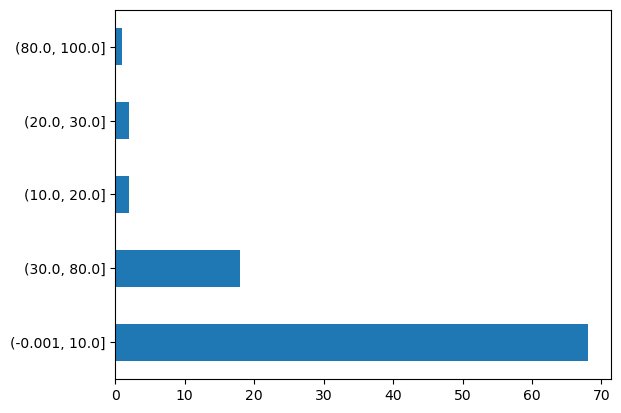

In [11]:
previous_hits['HetISq'].value_counts(bins=[0, 10, 20, 30, 80, 100]).plot(kind='barh')

In [12]:
previous_hits['HetISq'].value_counts(bins=[0, 10, 20, 30, 80, 100])

(-0.001, 10.0]    68
(30.0, 80.0]      18
(10.0, 20.0]       2
(20.0, 30.0]       2
(80.0, 100.0]      1
Name: HetISq, dtype: int64

In [ ]:
sig_previous_hits = previous_hits[previous_hits['P-value']<0.05]
sig_previous_hits.reset_index(drop=True, inplace=True)
sig_previous_hits

# Pull out --assoc in PLINK for these variants

## IPDGC – Nigeria – AFR - NC

In [ ]:
%%bash 

module load plink/1.9

plink --bfile ${NG_AFR_NEUROCHIP} \
--extract ${WORK_DIR}/data/other/compareGWAS/PD-hits-allGWASes-KimFooNalls-MarkerNamesONLY.txt \
--assoc --out ${WORK_DIR}/data/other/compareGWAS/NG_AFR_NEUROCHIP_previousHits_assoc

## GP2 – AFR (includes Nigerian NB)

In [ ]:
%%bash 

module load plink/1.9

plink --bfile ${UPDATED_GP2_v4_AFR} \
--extract ${WORK_DIR}/data/other/compareGWAS/PD-hits-allGWASes-KimFooNalls-MarkerNamesONLY.txt \
--assoc --out ${WORK_DIR}/data/other/compareGWAS/UPDATED_GP2_v4_AFR_previousHits_assoc

## GP2 – AAC

In [ ]:
%%bash 

module load plink/1.9

plink --bfile ${UPDATED_GP2_v4_AAC} \
--extract ${WORK_DIR}/data/other/compareGWAS/PD-hits-allGWASes-KimFooNalls-MarkerNamesONLY.txt \
--assoc --out ${WORK_DIR}/data/other/compareGWAS/UPDATED_GP2_v4_AAC_previousHits_assoc

## Read in Files

In [ ]:
previous_hits = pd.read_csv(f"{WORK_DIR}/data/other/compareGWAS/AFR-AAC-META-previousHits-allGWASes-KimFooNalls.csv")
previous_hits

In [ ]:
NG_AFR_NEUROCHIP_previousHits_assoc = pd.read_csv(f"{WORK_DIR}/data/other/compareGWAS/NG_AFR_NEUROCHIP_previousHits_assoc.assoc", delim_whitespace=True, usecols=['SNP','A1','F_A','F_U'])
NG_AFR_NEUROCHIP_previousHits_assoc.columns = ['MarkerName', 'Allele1', 'F_A_NG-NC', 'F_U_NG-NC']
NG_AFR_NEUROCHIP_previousHits_assoc

In [ ]:
GP2_AFR_previousHits_assoc = pd.read_csv(f"{WORK_DIR}/data/other/compareGWAS/UPDATED_GP2_v4_AFR_previousHits_assoc.assoc", delim_whitespace=True, usecols=['SNP','F_A','F_U'])
GP2_AFR_previousHits_assoc.columns = ['MarkerName','F_A_GP2-AFR', 'F_U_GP2-AFR']
GP2_AFR_previousHits_assoc

In [ ]:
GP2_AAC_previousHits_assoc = pd.read_csv(f"{WORK_DIR}/data/other/compareGWAS/UPDATED_GP2_v4_AAC_previousHits_assoc.assoc", delim_whitespace=True, usecols=['SNP','F_A','F_U'])
GP2_AAC_previousHits_assoc.columns = ['MarkerName', 'F_A_GP2-AAC', 'F_U_GP2-AAC']
GP2_AAC_previousHits_assoc

In [ ]:
previous_hits_wAFR = pd.merge(previous_hits, GP2_AFR_previousHits_assoc, on=['MarkerName'], how="left")
previous_hits_wAFR_wAAC = pd.merge(previous_hits_wAFR, GP2_AAC_previousHits_assoc, on=['MarkerName'], how="left")
previous_hits_wAFR_wAAC

In [30]:
%%bash 

head -1 ${WORK_DIR}/data/other/compareGWAS/UPDATED_GP2_v4_AFR_previousHits_assoc.assoc
grep "chr16:50702745:A:G" ${WORK_DIR}/data/other/compareGWAS/UPDATED_GP2_v4_AFR_previousHits_assoc.assoc

 CHR                 SNP         BP   A1      F_A      F_U   A2        CHISQ            P           OR 
  16  chr16:50702745:A:G   50702745    G   0.4782   0.4649    A        0.594       0.4409        1.055 


In [33]:
%%bash 
head -1 ${WORK_DIR}/data/other/compareGWAS/AFR-AAC-META-previousHits-allGWASes-KimFooNalls.csv
grep "chr16:50702745:A:G" ${WORK_DIR}/data/other/compareGWAS/AFR-AAC-META-previousHits-allGWASes-KimFooNalls.csv

MarkerName,rsID,GWAS,Allele1,Allele2,Effect,StdErr,P-value,Direction,HetISq,HetChiSq,HetDf,HetPVal
chr16:50702745:A:G,rs6500328,Nalls et al. 2019,A,G,-0.0517,0.0552,0.3488,----,0.0,0.562,3,0.9052


# Remove related individuals in GP2 EUR 

In [8]:
# Pull the FID and IID from the projected PCs, as those samples have passed QC
projected_pcs = pd.read_csv("projected_pcs.csv")
projected_pcs_eur = projected_pcs[projected_pcs['label']=="EUR"]
projected_pcs_eur_subset = projected_pcs_eur[['FID', 'IID']]
projected_pcs_eur_subset.to_csv(f"{WORK_DIR}/data/other/compareGWAS/GP2_release4_QCd_toKeep.txt", sep="\t", index=False)

In [ ]:
%%bash

module load plink

plink2 --pfile /data/GP2/releases/gp2tier2/release4_14022023/raw_genotypes/EUR/EUR_maf_hwe_release4 \
--keep ${WORK_DIR}/data/other/compareGWAS/GP2_release4_QCd_toKeep.txt \
--king-cutoff 0.088 \
--make-bed --out ${WORK_DIR}/data/other/compareGWAS/EUR_raw_noRelateds

In [15]:
%%bash

awk '{print $1,$2}' ${WORK_DIR}/data/other/compareGWAS/EUR_raw_noRelateds.fam > ${WORK_DIR}/data/other/compareGWAS/EUR_raw_noRelateds_toKeep.txt

In [ ]:
%%bash

module load plink/1.9

plink --bfile ${WORK_DIR}/data/other/compareGWAS/EUR_release4_allchr \
--keep ${WORK_DIR}/data/other/compareGWAS/EUR_raw_noRelateds_toKeep.txt \
--allow-no-sex \
--make-bed --out ${WORK_DIR}/data/other/compareGWAS/EUR_imputed_allchr_noRelateds

In [ ]:
%%bash 

module load plink/1.9

plink --bfile ${WORK_DIR}/data/other/compareGWAS/EUR_imputed_allchr_noRelateds \
--extract ${WORK_DIR}/data/other/compareGWAS/PD-hits-allGWASes-KimFooNalls-MarkerNamesONLY.txt \
--allow-no-sex \
--assoc --out ${WORK_DIR}/data/other/compareGWAS/EUR_imputed_allchr_noRelateds_previousHits_assoc

In [ ]:
GP2_EUR_previousHits_assoc = pd.read_csv(f"{WORK_DIR}/data/other/compareGWAS/EUR_imputed_allchr_noRelateds_previousHits_assoc.assoc", delim_whitespace=True, usecols=['SNP','F_A','F_U'])
GP2_EUR_previousHits_assoc.columns = ['MarkerName', 'F_A_GP2-EUR', 'F_U_GP2-EUR']
GP2_EUR_previousHits_assoc

In [ ]:
previous_hits_wAFR_wAAC_wEUR = pd.merge(previous_hits_wAFR_wAAC, GP2_EUR_previousHits_assoc, on=['MarkerName'], how="left")
previous_hits_wAFR_wAAC_wEUR

In [30]:
previous_hits_wAFR_wAAC_wEUR.to_csv("/data/GP2/projects/2023_02_MBM_AFR_AAC_GWAS/data/other/compareGWAS/previous_hits_wAFR_wAAC_wEUR_GP2_release4.csv", index=False)